In [1]:
import pandas as pd
import numpy as np

from google.oauth2 import service_account
from google.cloud import bigquery

In [2]:
SERVICE_ACCOUNT_FILE = "./key/api_key_carsharing.json"  # 키 json 파일
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)
project_id = "carsharing-454809"
dataset_name = "carsharing"
client = bigquery.Client(credentials=credentials, project=project_id)

def import_bigquery_data(query):
    query_job = client.query(query)
    return query_job.to_dataframe()

In [3]:
query1 = (f"""select * from {project_id}.{dataset_name}.licenses""")
query2 = (f"""select * from {project_id}.{dataset_name}.greencars""")
query3 = (f"""select * from {project_id}.{dataset_name}.transports""")
query4 = (f"""select * from {project_id}.{dataset_name}.sites""")

In [4]:
df2_licenses = import_bigquery_data(query1)
filtered_df1_greencar = import_bigquery_data(query2)
df3_transport = import_bigquery_data(query3)
df4_poi = import_bigquery_data(query4)
top_100 = df4_poi.head(100)

In [5]:
region_total_mapping = {
    '서울특별시': ['서울']+sorted([
                        "종로구", "중구", "용산구", "성동구", "광진구", "동대문구", "중랑구", 
                        "성북구", "강북구", "도봉구", "노원구", "은평구", "서대문구", "마포구", 
                        "양천구", "강서구", "구로구", "금천구", "영등포구", "동작구", "관악구", 
                        "서초구", "강남구", "송파구", "강동구"
                        ], reverse=True),
    '세종특별자치시':["세종"],
    '부산광역시': ["부산"],
    '대구광역시': ['대구'],
    '인천광역시': ['인천'],
    '광주광역시': ["광주광역시"],
    '대전광역시': ["대전"],
    '울산광역시': ["울산"],
    '광주광역시': ["광주"],
    '경기도': ['경기', '수원시', '고양시', '화성시', '성남시', '용인시', '부천시', '안양시', '시흥시', '기타 경기도 지역'],
    '강원도': ['강원', '춘천시', '강릉시', '원주시', '기타 강원도 지역'],
    '경상남도': ['경남', '창원시', '김해시', '기타 경상남도 지역'],
    '경상북도': ['경북', '포항시', '경주시', '기타 경상북도 지역'],
    '전라남도': ['전남', '여수시', '순천시', '목포시', '기타 전라남도 지역'],
    '전라북도': ['전북', '전주시', '군산시', '익산시', '기타 전라북도 지역'],
    '충청남도': ['충남', '천안시', '아산시', '기타 충청남도 지역'],
    '충청북도': ['충북', '청주시', '충주시', '기타 충청북도 지역'],
    '제주특별자치도': ['제주', '서귀포']}

In [6]:
# 주소 encoding 컬럼 추출
address_columns = [
    col for col in filtered_df1_greencar.columns
    if col not in ['zoneName', 'address', 'latitude', 'longitude', 'cluster', 'core', 'radius']
]

# 각 주소 컬럼별 차고지 갯수 계산
garage_counts = {
    col: filtered_df1_greencar[col].sum() for col in address_columns
}

# 결과를 DataFrame으로 변환
df_garage = pd.DataFrame(list(garage_counts.items()), columns=['Region', 'Garage_Count'])
df_garage = df_garage.sort_values(by='Garage_Count', ascending=False).reset_index(drop=True)

address_list = list(region_total_mapping.keys())
df_garage = df_garage[df_garage['Region'].isin(address_list)]
df_garage


,Region,Garage_Count
0,서울특별시,491
1,경기도,446
3,부산광역시,153
4,인천광역시,137
5,경상북도,93
6,대구광역시,91
7,경상남도,90
8,광주광역시,68
11,충청남도,46
12,전라남도,45


In [7]:
import altair as alt

# 막대 그래프 생성
chart = alt.Chart(df_garage).mark_bar().encode(
    x=alt.X('Garage_Count:Q', title='Garage Count'),
    y=alt.Y('Region:O', sort='-x', title='Region'),  # 내림차순 정렬
    tooltip=['Region', 'Garage_Count']  # Tooltip에 추가 정보 표시
).properties(
    title='Garage Count by Address',
    width=800,
    height=800
)

chart

alt.Chart(...)

In [12]:
df_garage_licenses = pd.merge(df_garage, df2_licenses, on='Region', how='outer')
df_garage_licenses['license'] = df_garage_licenses['license'].astype(int)
df_garage_licenses

,Region,Garage_Count,license
0,서울특별시,491,6024859
1,경기도,446,8708245
2,부산광역시,153,1883885
3,인천광역시,137,1823597
4,경상북도,93,1528795
5,대구광역시,91,1461003
6,경상남도,90,1940391
7,광주광역시,68,866628
8,충청남도,46,1266080
9,전라남도,45,987358


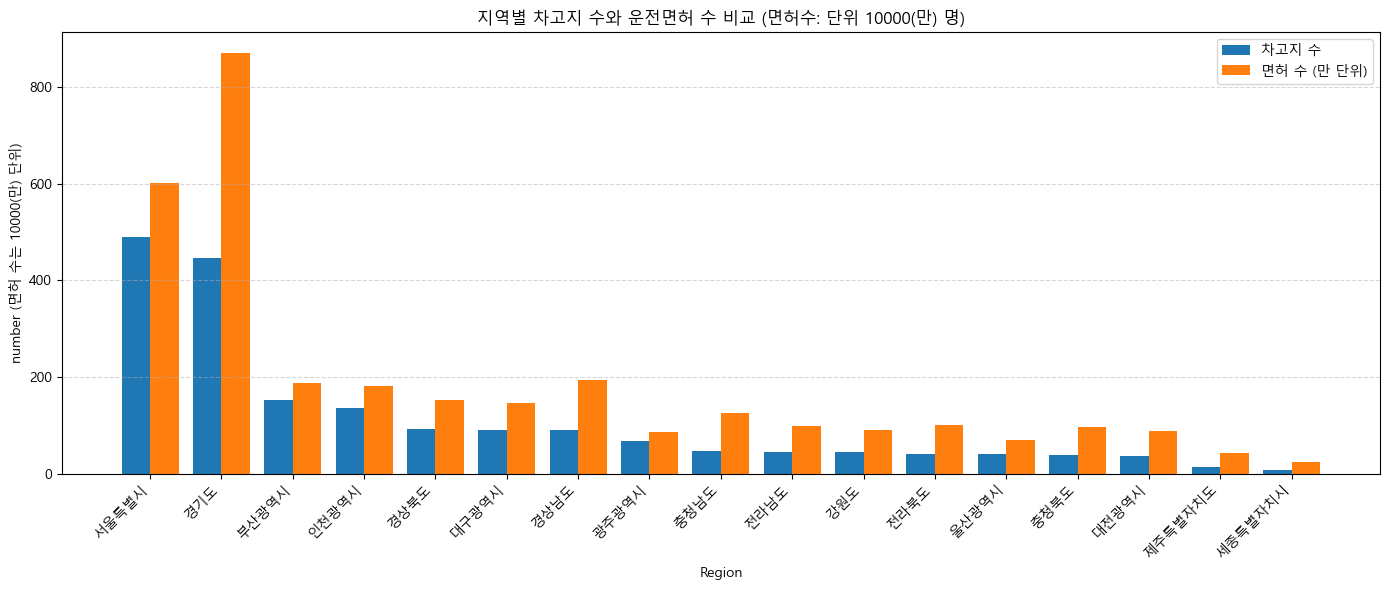

In [ ]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 (윈도우 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터프레임 이름: df_garage_licenses
x = np.arange(len(df_garage_licenses))
bar_width = 0.4

# 면허 수 천 단위로 나누기
license_scaled = df_garage_licenses['license'] / 10000  # 단위: 만 명

plt.figure(figsize=(14, 6))

# 차고지 수
plt.bar(x - bar_width/2, df_garage_licenses['Garage_Count'], width=bar_width, label='차고지 수')

# 면허 수 (단위 조정)
plt.bar(x + bar_width/2, license_scaled, width=bar_width, label='면허 수 (만 단위)')

# x축 설정
plt.xticks(x, df_garage_licenses['Region'], rotation=45, ha='right')
plt.xlabel('Region')
plt.ylabel('number (면허 수는 10000(만) 단위)')
plt.title('지역별 차고지 수와 운전면허 수 비교 (면허수: 단위 10000(만) 명)')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


In [13]:
df_garage_licenses["relative_Garage_Count"] = df_garage_licenses["Garage_Count"]/df_garage_licenses["Garage_Count"].max()
df_garage_licenses["relative_license"] = df_garage_licenses["license"]/df_garage_licenses["license"].max()
df_garage_licenses["relative_score"] = (df_garage_licenses["relative_Garage_Count"])/df_garage_licenses["relative_license"]


In [14]:
# 점 그래프: Garage_Count vs license
scatter_chart = alt.Chart(df_garage_licenses).mark_circle(size=100).encode(
    x=alt.X('Garage_Count:Q', title='Garage Count'),
    y=alt.Y('license:Q', title='License Count'),
    color=alt.Color('Region:N', title='Region'),
    tooltip=['Region', 'Garage_Count', 'license']
).properties(
    title='Garage Count vs License Count',
    width=800,
    height=400
)

scatter_chart


alt.Chart(...)

In [ ]:
def generate_circle(lat, lon, radius, n_points=50):
    """
    중심 좌표(lat, lon)와 반경(radius)를 이용해 원형 다각형의 좌표를 생성.
    :param lat: 위도
    :param lon: 경도
    :param radius: 반경 (미터 단위)
    :param n_points: 다각형을 구성할 점의 수
    :return: 원형 다각형의 좌표 리스트
    """
    angles = np.linspace(0, 2 * np.pi, n_points)
    earth_radius = 6371000  # 지구 반경 (미터)
    
    # 위도와 경도의 단위를 라디안으로 변환
    lat_radians = np.radians(lat)
    lon_radians = np.radians(lon)
    
    circle_coords = []
    for angle in angles:
        d_lat = radius / earth_radius * np.cos(angle)
        d_lon = radius / (earth_radius * np.cos(lat_radians)) * np.sin(angle)
        
        new_lat = lat_radians + d_lat
        new_lon = lon_radians + d_lon
        
        circle_coords.append([np.degrees(new_lon), np.degrees(new_lat)])
    
    return circle_coords

In [ ]:
import hdbscan

# 1. 위도와 경도 데이터 선택
coords = filtered_df1_greencar[['latitude', 'longitude']].dropna()

# HDBSCAN 모델 학습 (coords는 위도와 경도 데이터)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
hdbscan_model.fit(coords)

# 클러스터 레이블 추가
filtered_df1_greencar['cluster'] = hdbscan_model.labels_

# 코어 멤버 여부 추가
filtered_df1_greencar['core'] = hdbscan_model.probabilities_ >= 0.5
# 코어 멤버 반경 설정 (예: 밀도의 역수를 반경으로 설정)
filtered_df1_greencar['radius'] = 1 / hdbscan_model.outlier_scores_  # 밀도가 높을수록 반경 작음


# 코어 멤버만 필터링
core_members = filtered_df1_greencar[filtered_df1_greencar['core']]

# 각 코어 멤버에 대해 원형 좌표 생성
core_members['polygon'] = core_members.apply(
    lambda row: generate_circle(row['latitude'], row['longitude'], row['radius']), axis=1
)

# 결과 확인
print(f"Number of core members: {len(core_members)}")
print(core_members.head())
# 결과 확인
num_clusters = len(set(hdbscan_model.labels_)) - (1 if -1 in hdbscan_model.labels_ else 0)
print(f"Number of clusters found: {num_clusters}")
print(filtered_df1_greencar['cluster'].value_counts())